In [1]:
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import math

In [2]:
#define sigmoid and its derivative for activation & backprop
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

def derivSigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Question 1 - Import Data

In [3]:
################################################################################
# CSE 253: Programming Assignment 1
# Code snippet by Michael
# Winter 2020
################################################################################
# We've provided you with the dataset in PA1.zip
################################################################################
# To install PIL, refer to the instructions for your system:
# https://pillow.readthedocs.io/en/5.2.x/installation.html
################################################################################
# If you don't have NumPy installed, please use the instructions here:
# https://scipy.org/install.html
################################################################################


''' 
list of face expressions (contempt, neutral are excluded) are:
1. anger
2. disgust
3. fear
4. happiness
5. sadness
6. surprise
'''

def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()


# example on how to use it
if __name__ == '__main__':
	# The relative path to your image directory
	data_dir = "./aligned/"
	dataset, cnt = load_data(data_dir)
	# test with happiness and anger
	images = balanced_sampler(dataset, cnt, emotions=['happiness', 'anger'])
	display_index = 0
	display_face(images['anger'][display_index])

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
happiness: 45 # of images
anger: 45 # of images
Converting from array to PIL Image


In [4]:
K = 10 # number of sections after folding
M = 50 # maximum number of epochs


## Training Procedure

In [5]:
#list happiness as a 1, anger as a 0
X = images['happiness'] + images['anger']
y = [1] * 45 + [0] * 45

#get my feature - label pairs zipped together
all_happy_angry = list(zip(X,y))

#randomize the dataset so I can fold properly

random.shuffle(all_happy_angry)

def kfold(data, k=10):
    folds = []
    size = int((1/k) * len(data))
    for i in range(0,k):
        folds.append(data[i*size : (i+1)*size])
    return folds


In [6]:
folds = kfold(all_happy_angry)
print(len(folds[0]) == len(folds[1]))
print(len(folds))

True
10


## Task 5 - Logistic Regression

In [177]:
class LogisticRegression:
    
    def __init__(self, lr, dim):
        self.lr = lr
        self.w = np.zeros((dim, 1)) 
    
    def stochastic_gradient_descent(self, X, labels):
        indices = [i for i in range(len(labels))]
        np.random.shuffle(indices)
        for i in indices:
            
            # make predition
            data = X[i]
            label = labels[i]
            predicted = sigmoid(data.dot(self.w))
            error = label - predicted
            
            # update weights
            for i in range(len(self.w)):
                grad = error * data[i]
                self.w[i] += self.lr * grad
            
    def probabilities(self, X):
        return sigmoid(X.dot(self.w))

    
    def batch_gradient_descent(self, X, labels):
        predicted = self.probabilities(X)
        error = labels - predicted
        grad = X.T.dot(error)
        print("Grad shape")
        print(grad.shape)
        grad = np.sum(grad, axis=1).reshape(grad.shape[0], 1)
        print(grad.shape)
        self.w += self.lr * grad
        

    def loss(self, labels, predicted):
        log_predicted = np.log(predicted)
        cost = log_predicted*labels + (1 - labels) * log_predicted
        return - cost.sum() / len(labels)


In [172]:
lr = LogisticRegression(0.1, 3)

In [155]:
lr.loss(np.array([1,1]), np.array([1,1]))

-0.0

In [156]:
lr.loss(np.array([1,1]), np.array([0.5,1]))

0.34657359027997264

In [157]:
test_data = np.array([[0.9,0.22,0.44], [0.0,0.22,0.44]])

for i in range(50):
    lr.stochastic_gradient_descent(test_data, np.array([0, 1]))

In [158]:
lr.w

array([[-1.5231269 ],
       [ 0.16073021],
       [ 0.32146041]])

In [159]:
lr.probabilities(test_data)

X shape
(2, 3)
W shape
(3, 1)


array([[0.23254234],
       [0.54408602]])

In [160]:
lr.loss(np.array([0, 1]), lr.probabilities(test_data))

X shape
(2, 3)
W shape
(3, 1)


2.067330862618437

In [127]:
5 

[0, 0, 0, 0, 1, 0]

[0, 0, 0, 0, 1, 0]

## Softmax

In [176]:
emotions_mapping = ["fear", "surprise", "sadness", "happiness", "anger", "disgust"]


class SoftmaxRegression:
    
    def __init__(self, lr, dim, c):
        self.lr = lr
        self.w = np.zeros((dim, c)) 
    
    def stochastic_gradient_descent(self, X, labels):
        indices = [i for i in range(len(labels))]
        np.random.shuffle(indices)
        for i in indices:
            
            # make predition
            data = X[i]
            label = labels[i]
            predicted = self.probabilities(data)
            error = label - predicted
            
            # update weights
            for i in range(len(self.w)):
                grad = error * data[i]
                self.w[i] += self.lr * grad
            
    def probabilities(self, X):
        return np.exp(X.dot(self.w)) / np.sum(np.exp(X.dot(self.w)), axis=0)

    
    def batch_gradient_descent(self, X, labels):
        predicted = self.probabilities(X)
        error = labels - predicted
        grad = X.T.dot(error)
        grad = np.sum(grad, axis=1).reshape(grad.shape[0], 1)
        self.w += self.lr * grad
        

    def loss(self, labels, predicted):
        return -np.sum(np.sum(labels.T.dot(np.log(predicted)))) # can't have zero values 



In [169]:
softmax = SoftmaxRegression(0.02, 4, 2)

test_data = np.array([[0.3,0.22,0.44, 0.44], [0.0,0.12,0.2, 0.2]])



softmax.loss(np.array([[1, 0],[1,0]]), softmax.probabilities(test_data))

2.772588722239781

In [170]:
for i in range(1000):
    softmax.batch_gradient_descent(test_data, np.array([[1, 0],[1,0]]))

ValueError: operands could not be broadcast together with shapes (4,2) (4,) (4,2) 

In [31]:
softmax.w

array([[ 1.15572504, -1.15572504],
       [ 2.78524168, -2.78524168],
       [ 4.92458004, -4.92458004],
       [ 4.92458004, -4.92458004]])

In [32]:
softmax.probabilities(test_data)

array([[0.95207653, 0.04792347],
       [0.04792347, 0.95207653]])

In [166]:
class PCA:
    def __init__(self, square_data, k=10): # k defaults to 10
        self.square_data = square_data
        M, rows, columns = self.square_data.shape
        self.k = k
        self.num_examples = M
        self.image_vec = np.reshape(square_data, (M, rows*columns))
        self.mean_face = np.mean(self.image_vec, axis=0)
        self.components, self.singular_values = self.get_components()
    
    def get_components(self):
        Phi = self.image_vec - self.mean_face
        A = Phi
        C = np.matmul(A, A.T)
        C = np.divide(C, self.num_examples)
        evals, Vi = np.linalg.eigh(C)
        z = list(zip(evals,Vi))
        z.sort(reverse=True)
        #sort eigenvectors by corresponding eigenvalue
        sorted_Vi = np.array([x[1] for x in z])
        #take only the top k eigenvectors
        pc = sorted_Vi[:self.k]
        #final components (num pixels by k matrix)
        components = np.matmul(A.T, pc.T)
        #get singluar values
        sorted_evals = np.array([x[0] for x in z])
        postive_evals = sorted_evals[:self.k]
        singular_values = np.sqrt(postive_evals)
        return components, singular_values
        

    def transform(self, images): #take an image, and pc's, and output compressed image
        M, rows, columns = images.shape
        flat_images = np.reshape(images, (M, rows*columns)) - self.mean_face
        compressed_image_vectors = np.matmul(flat_images, self.components)/self.singular_values
        return compressed_image_vectors

Fold: 0
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[ 3.43167881e+03  4.35258712e+03  4.48737681e+03 -2.38030986e+04
  -9.08227933e+03  2.13267871e+04  2.95923823e+04  2.41956137e+04
   3.02555568e+04 -2.13808225e+04]
 [ 5.48217821e+03  1.27570002e+03  6.97694172e+03 -2.98496972e+04
  -1.28438453e+04  3.21187188e+04  3.17442432e+04  3.30881545e+04
   3.16723539e+04 -4.43550635e+04]
 [ 7.34725869e+03 -8.34594289e+02  9.67601730e+02 -2.77903060e+04
  -1.54745469e+04  2.44413760e+04  2.86142902e+04  3.86142300e+04
   3.46312194e+04 -2.37955951e+04]
 [-2.66760644e+03 -2.91977118e+03  5.06326633e+03 -1.56883975e+04
  -3.90552777e+03  8.60652676e+03  1.95179009e+03  4.43611974e+03
   2.45604440e+04 -2.00607619e+04]
 [ 9.56807004e+03  3.36978796e+03  6.01189917e+03 -1.34202748e+04
  -1.09778357e+04  1.76961715e+04  2.23384166e+04  7.67681144e+03
   9.

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in multiply


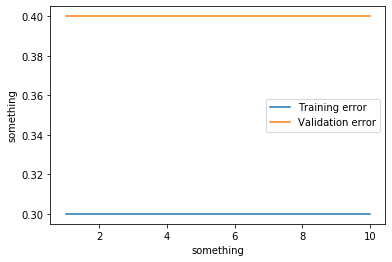

Fold: 1
Training index: 0
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[-8.28392828e+03  5.51824581e+03 -1.45318458e+04 -1.45586936e+04
  -2.91721117e+04  3.00078592e+04  2.20561376e+04 -1.29037724e+04
  -6.00531720e+04 -1.72512053e+04]
 [ 8.93402131e+03 -1.07339349e+04  1.44998306e+04  2.15014184e+04
   2.20087687e+04 -1.81565460e+04 -2.00947377e+04  8.15174825e+03
   4.88406423e+04  1.55575987e+04]
 [ 4.47608474e+03 -1.81301653e+03  3.75560657e+03  1.32141591e+04
   1.23430256e+04 -9.99729231e+03 -1.06115778e+04  6.40560421e+03
   2.44188429e+04  1.54125596e+04]
 [ 6.00704031e+03 -1.54296871e+04  4.39582365e+03  1.66754052e+04
   1.62143103e+02  1.98546370e+03 -1.43727821e+04 -6.77275141e+03
   3.25198442e+04 -9.11501337e+03]
 [-1.06636920e+04  1.11169575e+04 -2.01702903e+04 -2.09345106e+04
  -2.72001283e+04  3.07084942e+04  1.04299175e+04 -1.35768634e+04
  -4.

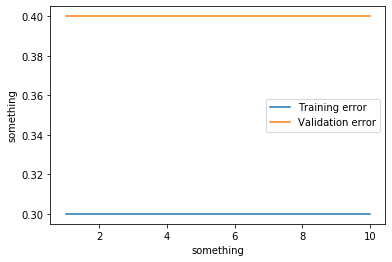

Fold: 2
Training index: 0
Training index: 1
Training index: 4
Training index: 5
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[ 8.50430524e+03 -1.81994198e+04 -2.17546480e+04  1.38650844e+04
  -8.58919834e+03  4.10115868e+02 -2.89321917e+04  2.72530389e+04
   1.44951757e+04 -1.69477792e+04]
 [-6.29813493e+03  1.01657225e+04  8.95757990e+03 -9.15518170e+03
   8.11746211e+03  3.18824456e+03  4.06261194e+04 -1.52078310e+04
  -3.35152153e+04  2.04663024e+04]
 [-5.18287964e+03  8.10882009e+03  9.13989083e+03  7.33018147e+02
   8.92345176e+03 -2.85523162e+03  2.26591647e+04  4.50789287e+03
  -8.71580604e+03  1.40124938e+04]
 [-4.30244992e+03 -5.16653086e+03 -7.70745468e+03  8.80065297e+02
  -8.95575186e+03 -9.08734674e+03  2.23335317e+04 -2.10451224e+04
  -1.76900715e+04  7.85947153e+03]
 [ 9.50695751e+03 -2.23760423e+04 -2.75184647e+04  1.84078787e+04
  -2.21698185e+04 -1.39726175e+04 -5.51044535e+04  1.31343685e+04
   3.

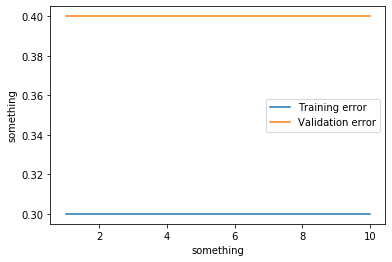

Fold: 3
Training index: 0
Training index: 1
Training index: 2
Training index: 5
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[-9.75410093e+02  1.57772942e+04 -6.03624146e+03  2.58657455e+04
  -6.05397947e+01  1.99920243e+04 -1.65527350e+04  4.15475143e+04
   2.08686740e+04 -7.06234405e+04]
 [ 2.53139076e+03 -9.97688522e+03 -4.07980812e+03 -2.99910985e+04
   2.31283798e+03 -1.79373906e+04  1.32473416e+04 -3.97183030e+04
  -1.60215316e+04  4.68662687e+04]
 [-2.89502936e+02 -4.01971840e+03 -7.23549745e+03 -1.15973185e+04
   1.65345950e+04 -8.54230924e+03  1.21600740e+04 -1.31503221e+04
   5.19816554e+03  1.59660446e+04]
 [ 3.95578201e+03 -2.86076351e+03 -5.09459721e+03 -1.83641986e+04
  -8.68717433e+03  1.53392418e+03  3.46605100e+03 -1.51377895e+04
  -2.91343897e+01  8.74053794e+03]
 [ 7.70367253e+01  1.35262027e+04 -9.32763396e+02  4.28904265e+04
  -8.12113222e+03  3.38960539e+04 -1.64329597e+04  5.48927485e+04
   2.

[[-9.75410093e+02  1.57772942e+04 -6.03624146e+03  2.58657455e+04
  -6.05397947e+01  1.99920243e+04 -1.65527350e+04  4.15475143e+04
   2.08686740e+04 -7.06234405e+04]
 [ 2.53139076e+03 -9.97688522e+03 -4.07980812e+03 -2.99910985e+04
   2.31283798e+03 -1.79373906e+04  1.32473416e+04 -3.97183030e+04
  -1.60215316e+04  4.68662687e+04]
 [-2.89502936e+02 -4.01971840e+03 -7.23549745e+03 -1.15973185e+04
   1.65345950e+04 -8.54230924e+03  1.21600740e+04 -1.31503221e+04
   5.19816554e+03  1.59660446e+04]
 [ 3.95578201e+03 -2.86076351e+03 -5.09459721e+03 -1.83641986e+04
  -8.68717433e+03  1.53392418e+03  3.46605100e+03 -1.51377895e+04
  -2.91343897e+01  8.74053794e+03]
 [ 7.70367253e+01  1.35262027e+04 -9.32763396e+02  4.28904265e+04
  -8.12113222e+03  3.38960539e+04 -1.64329597e+04  5.48927485e+04
   2.37905171e+04 -6.31576695e+04]
 [-1.21297699e+03  1.78968736e+04 -4.29965699e+03  5.28975951e+04
  -4.44716680e+03  3.06339925e+04 -2.25776104e+04  6.00717187e+04
   2.84397008e+04 -9.04204974e+04

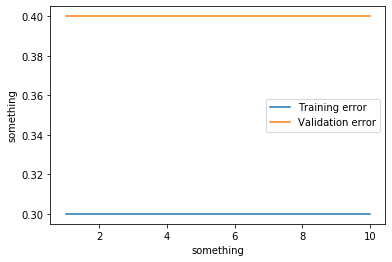

Fold: 4
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[-4.20510036e+03  4.46477402e+02  1.65163081e+04  3.90814999e+03
  -1.71650657e+04 -9.16512943e+03 -2.06723686e+04  1.67009087e+04
  -4.33059105e+04  2.99302353e+03]
 [ 4.32942456e+03 -5.44600053e+03 -2.40327823e+04 -1.95683700e+03
   2.05040974e+04 -9.51815155e+02  3.60898329e+04 -1.04041463e+04
   2.20919919e+04  4.50608412e+03]
 [-3.01197938e+03 -6.12437968e+03 -1.06738824e+04  2.45806590e+03
   1.03486596e+04  9.58509070e+02  2.31803599e+04 -6.50194404e+03
   1.40252184e+04  1.41082771e+04]
 [ 4.53606694e+03 -1.65814907e+02 -9.57140038e+03 -5.28263371e+03
   1.29601463e+04 -1.38261404e+04  1.67187847e+04  8.49647221e+03
   4.08923360e+03 -5.52542145e+03]
 [-5.55956862e+03  7.35336258e+03  2.31697453e+04 -8.43587074e+02
  -3.09602787e+04 -1.56771533e+04 -4.99144393e+04  5.52115280e+03
  -2.

[[-4.20510036e+03  4.46477402e+02  1.65163081e+04  3.90814999e+03
  -1.71650657e+04 -9.16512943e+03 -2.06723686e+04  1.67009087e+04
  -4.33059105e+04  2.99302353e+03]
 [ 4.32942456e+03 -5.44600053e+03 -2.40327823e+04 -1.95683700e+03
   2.05040974e+04 -9.51815155e+02  3.60898329e+04 -1.04041463e+04
   2.20919919e+04  4.50608412e+03]
 [-3.01197938e+03 -6.12437968e+03 -1.06738824e+04  2.45806590e+03
   1.03486596e+04  9.58509070e+02  2.31803599e+04 -6.50194404e+03
   1.40252184e+04  1.41082771e+04]
 [ 4.53606694e+03 -1.65814907e+02 -9.57140038e+03 -5.28263371e+03
   1.29601463e+04 -1.38261404e+04  1.67187847e+04  8.49647221e+03
   4.08923360e+03 -5.52542145e+03]
 [-5.55956862e+03  7.35336258e+03  2.31697453e+04 -8.43587074e+02
  -3.09602787e+04 -1.56771533e+04 -4.99144393e+04  5.52115280e+03
  -2.74394890e+04 -1.48981470e+04]
 [-6.12347655e+03 -1.97457073e+01  2.56983373e+04 -1.45268093e+03
  -3.64528600e+04 -1.59114604e+04 -5.24813474e+04  6.16232123e+02
  -5.20679088e+04 -2.51243908e+03

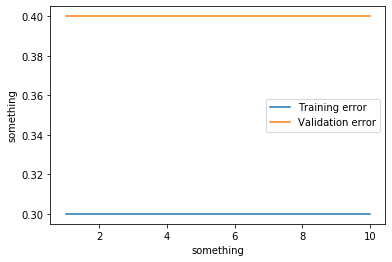

Fold: 5
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[-1.41404039e+03 -5.25835468e+02 -3.23982490e+03  1.56501160e+04
  -1.97955542e+04 -5.55548171e+04 -3.42740022e+04  3.55635241e+03
  -6.98304789e+04  2.60536243e+03]
 [-1.29622391e+02 -1.18979498e+03  5.02949080e+03 -1.62708675e+04
   9.05814984e+03  6.03599949e+04  2.08434432e+04 -1.80757521e+04
   8.08801582e+04  1.85676716e+04]
 [ 6.32018508e+02  8.84968094e+02  5.98106636e+03 -7.90272589e+03
   8.86015401e+03  3.63442291e+04  1.58506923e+04 -3.52237232e+03
   2.97999900e+04  2.96962167e+04]
 [ 4.92607884e+02 -6.47549225e+02  4.06847075e+03 -1.66765510e+04
   7.68511185e+02  3.28950937e+04  6.91730543e+03 -3.87823289e+04
   4.73241451e+04 -1.85322248e+03]
 [-1.32994640e+03  3.01156645e+03 -9.94164246e+03  7.24146558e+03
  -1.22799541e+04 -8.48654789e+04 -1.61314808e+04  9.44431583e+02
  -8.

[[-1.41404039e+03 -5.25835468e+02 -3.23982490e+03  1.56501160e+04
  -1.97955542e+04 -5.55548171e+04 -3.42740022e+04  3.55635241e+03
  -6.98304789e+04  2.60536243e+03]
 [-1.29622391e+02 -1.18979498e+03  5.02949080e+03 -1.62708675e+04
   9.05814984e+03  6.03599949e+04  2.08434432e+04 -1.80757521e+04
   8.08801582e+04  1.85676716e+04]
 [ 6.32018508e+02  8.84968094e+02  5.98106636e+03 -7.90272589e+03
   8.86015401e+03  3.63442291e+04  1.58506923e+04 -3.52237232e+03
   2.97999900e+04  2.96962167e+04]
 [ 4.92607884e+02 -6.47549225e+02  4.06847075e+03 -1.66765510e+04
   7.68511185e+02  3.28950937e+04  6.91730543e+03 -3.87823289e+04
   4.73241451e+04 -1.85322248e+03]
 [-1.32994640e+03  3.01156645e+03 -9.94164246e+03  7.24146558e+03
  -1.22799541e+04 -8.48654789e+04 -1.61314808e+04  9.44431583e+02
  -8.57415831e+04 -2.83636498e+04]
 [-2.36964099e+03  4.53600915e+03 -1.37296258e+04  2.26629792e+04
  -1.95038807e+04 -1.12627256e+05 -4.00945042e+04  2.33077393e+04
  -1.18150800e+05 -6.59042704e+03

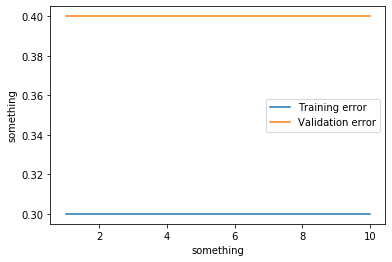

Fold: 6
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[-5.97524015e+03  2.22402581e+03 -2.54071687e+02  2.57024717e+04
  -2.11260441e+04 -2.38076736e+04  6.04263220e+03  1.85200227e+04
  -9.01460614e+04 -7.11391478e+04]
 [ 2.46160260e+03 -1.21823991e+04 -7.64222452e+02 -1.88736938e+04
   1.92612440e+04  1.92466367e+04 -5.26500329e+03 -3.25094955e+04
   5.70511560e+04  3.60702428e+04]
 [ 7.39903646e+02 -8.25490646e+03 -2.87436890e+03  1.85209588e+03
   1.07035556e+04  1.50298560e+04 -1.31327764e+03 -1.17713902e+04
   2.22836027e+04  8.78354195e+03]
 [-1.26307082e+02 -5.05663460e+03  2.09309524e+03 -1.40997928e+04
   4.92538233e+03  9.67103193e+03 -4.51404350e+03 -1.88271789e+04
   1.93015324e+04  1.15056792e+04]
 [-8.17617169e+03  1.59650388e+04  6.99555507e+02  1.76857763e+04
  -2.25464479e+04 -2.77667002e+04  1.08987909e+04  4.91779213e+04
  -8.

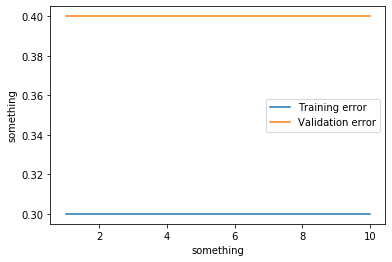

Fold: 7
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[ 1.41754034e+03  1.22810048e+04 -1.14181266e+04  1.86988233e+04
  -7.29342763e+03 -4.00043305e+04  1.87870482e+04  1.73144404e+04
   2.17913473e+04 -1.94906149e+04]
 [ 2.89998692e+03 -2.73538946e+03  9.31457902e+03 -1.90873354e+04
   1.03221610e+03  2.95684222e+04 -2.50381740e+04 -2.50411066e+03
  -1.81386019e+04 -2.77942207e+03]
 [ 6.56133766e+02 -6.08782333e+02  3.46213420e+03 -5.99108367e+03
   2.89145087e+03  1.34109177e+04 -1.76610712e+04  1.03812227e+04
  -1.49515527e+04 -2.03670925e+04]
 [ 6.26396358e+03  8.14387203e+03  4.37916127e+03  2.63406103e+02
  -9.28781646e+03  1.00890571e+04 -3.15258565e+04  1.74173221e+04
  -6.67752151e+03 -3.48783057e+03]
 [ 1.88579212e+03  9.60268677e+03 -1.04755938e+04  3.56340194e+04
  -5.57069584e+03 -4.67661088e+04  2.05695693e+04  6.65928948e+03
   1.

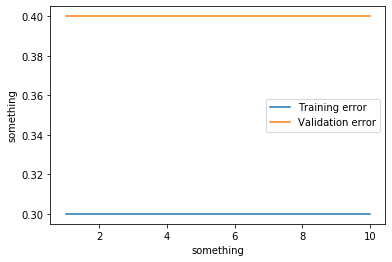

Fold: 8
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 7
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[ 6.79385976e+03 -4.86639652e+03 -2.47089960e+04 -4.32580995e+04
  -2.13831798e+04  3.49759261e+04  6.22470610e+04  1.42640391e+04
   1.17370721e+04 -3.69535418e+03]
 [-5.01062662e+03  7.52853552e+03  1.53314254e+04  4.03233808e+04
   1.64593616e+04 -2.23874353e+04 -5.21468622e+04 -2.09506652e+04
   9.17680343e+02  1.71763938e+03]
 [-7.44478761e+00  2.62741395e+03  5.62535702e+03  1.73340815e+04
   5.24883269e+03 -8.78282228e+03 -3.01494258e+04 -1.66286232e+04
   7.03053262e+02  1.59712344e+03]
 [-2.25877098e+03 -3.08068449e+02  7.68728636e+03  1.82518119e+04
   3.38266776e+03 -1.11213298e+04 -1.52410672e+04 -1.69054070e+04
   5.21651177e+03  7.74692795e+03]
 [ 5.66452627e+03 -1.10167795e+04 -1.60064302e+04 -5.81730446e+04
  -2.72148423e+04  1.66051273e+04  7.99974707e+04  2.39306807e+04
  -5.

[[ 6.79385976e+03 -4.86639652e+03 -2.47089960e+04 -4.32580995e+04
  -2.13831798e+04  3.49759261e+04  6.22470610e+04  1.42640391e+04
   1.17370721e+04 -3.69535418e+03]
 [-5.01062662e+03  7.52853552e+03  1.53314254e+04  4.03233808e+04
   1.64593616e+04 -2.23874353e+04 -5.21468622e+04 -2.09506652e+04
   9.17680343e+02  1.71763938e+03]
 [-7.44478761e+00  2.62741395e+03  5.62535702e+03  1.73340815e+04
   5.24883269e+03 -8.78282228e+03 -3.01494258e+04 -1.66286232e+04
   7.03053262e+02  1.59712344e+03]
 [-2.25877098e+03 -3.08068449e+02  7.68728636e+03  1.82518119e+04
   3.38266776e+03 -1.11213298e+04 -1.52410672e+04 -1.69054070e+04
   5.21651177e+03  7.74692795e+03]
 [ 5.66452627e+03 -1.10167795e+04 -1.60064302e+04 -5.81730446e+04
  -2.72148423e+04  1.66051273e+04  7.99974707e+04  2.39306807e+04
  -5.20219840e+03  2.67520586e+03]
 [ 9.46156227e+03 -8.88604897e+03 -2.98329663e+04 -7.79828283e+04
  -3.67823782e+04  4.00900089e+04  1.01245543e+05  2.47174244e+04
   1.65011755e+04 -1.39664705e+04

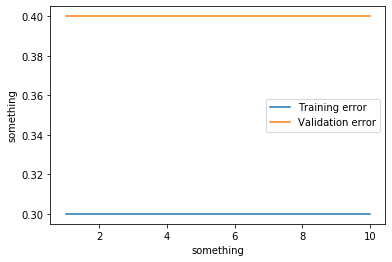

Fold: 9
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 7
Training index: 8
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[ 1.32870320e+04  1.57856867e+03  1.73286583e+04  4.69448667e+04
   3.40409685e+04  6.24666837e+03  8.44523364e+03 -6.50197531e+04
  -7.10103163e+04 -3.00584733e+03]
 [ 1.53610447e+04  1.06429690e+04  2.91403302e+04  3.19494069e+04
   4.58007682e+04  2.38338115e+04  1.96316259e+04 -5.47700437e+04
  -1.14196253e+05  2.49798549e+04]
 [-2.69719168e+03  1.81775900e+04  8.17119670e+03 -6.25972969e+03
   1.71636810e+04 -1.15228329e+04 -2.00963210e+02 -2.41664004e+04
  -1.05297487e+04 -2.15658719e+03]
 [ 1.20920697e+04  7.37239428e+02 -1.93697468e+02  2.32182851e+04
   1.39910298e+04  2.54482534e+04  7.77786630e+03 -3.21295901e+04
  -6.24971045e+04  1.45232767e+04]
 [-8.68678461e+03 -8.84223841e+03 -1.79881570e+04 -1.54406135e+04
  -3.59003791e+04 -1.00822475e+04 -1.07103576e+04  4.14050944e+04
   6.

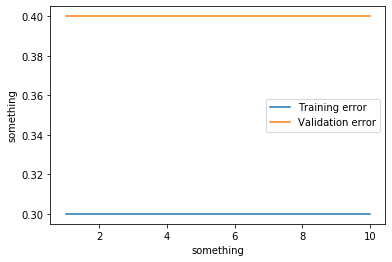

In [178]:
import matplotlib.pyplot as plt

EPOCHS = 10
K = 10

class EpochData:
    def __init__(self):
        self.acc = []
        self.error = []
    
    def save(self, acc, error):
        self.acc.append(acc)
        self.error.append(error)
        
    
    def score(self):
        return self.error[-1]
        
        
def transform(pca, data):
    return (pca.transform(data[0]), data[1])

def visualize_data(plots, legends, x_label, y_label):
    x = np.arange(1, len(plots[0]) + 1)
    for data in plots:
        plt.plot(x, data)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(legends)
    plt.show()
    
def split_x_y(data):
    return np.array([item[0] for item in data]), np.array([item[1] for item in data]) 


def train():
    best_model = None
    
    folds = kfold(all_happy_angry)
    k = len(folds)
    for fold in range(k):
        model = LogisticRegression(0.2, K) # model
        
        # split data
        val_data, test_data = split_x_y(folds[fold]), split_x_y(folds[(fold + 1) % k])
        train_data = None
        print("Fold: " + str(fold))
        for i in range(k):
            if i != fold and i != ((fold + 1) % k):
                print("Training index: " + str(i))
                if train_data is None:
                    train_data = folds[i]
                else:
                    train_data = np.concatenate((train_data, folds[i]))
        train_data = split_x_y(train_data)
        print(val_data[0].shape)
        print(test_data[0].shape)
        print(train_data[0].shape)


        pca = PCA(train_data[0], K)
        # PCA
        train_data, test_data, val_data = transform(pca, train_data), transform(pca, test_data), transform(pca, val_data)        
        
        validation_performance = EpochData()
        training_performance = EpochData()    
        
        for epoch in range(EPOCHS):
            print(train_data[0])
            model.batch_gradient_descent(train_data[0], train_data[1])
            
            training_error = model.loss(train_data[1], model.probabilities(train_data[0]))
            validation_error = model.loss()
            
            traning_acc = 0.3 #model.make_prediction()
            validation_acc = 0.4 #model.make_prediction()
            
            print("Training error: {}, validation error: {}, accuracy: {}".format(training_error, validation_error, traning_acc))
        
            # save
            validation_performance.save(validation_error, validation_acc)
            training_performance.save(training_error, traning_acc)
        
        
        # plot the graphs
        data_to_plot = [training_performance.error, validation_performance.error]
        legends = ["Training error", "Validation error"]
        visualize_data(data_to_plot,legends, "something", "something")
        
        # save the best model
        
        # save the validation data to the model
        model.epoch_data = validation_performance 
        
        if best_model is None:
            best_model = model
        elif best_model.epoch_data.score() > model.epoch_data.score():
            best_model = model
        
            

def test():
    pass

train()
#training_procedure()
